**THỰC HÀNH 1: PHÂN LỚP VĂN BẢN SỬ DỤNG PRE-TRAINED WORD EMBEDDING**


**Bài 1:**  
Thực hiện xây dựng mô hình dự đoán cho bài toán phân loại chủ đề (topic-based)
dựa trên bộ dữ liệu UIT-VSFC. Lưu ý: pre-trained embedding ở 2 bài phải trùng nhau

In [23]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [24]:
!pip install pyvi
!pip install keras
!pip install tensorflow

In [25]:
import pandas as pd
import numpy as np
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from pyvi import ViTokenizer


In [26]:
# load data

# training data
x_train = pd.read_csv('/content/drive/MyDrive/LAB_DS310/LAB01/Train/sents.txt', header=None, index_col=None, sep='\t')
y_train = pd.read_csv('/content/drive/MyDrive/LAB_DS310/LAB01/Train/topics.txt', header=None, index_col=None, sep='\t')

# dev data
x_dev = pd.read_csv('/content/drive/MyDrive/LAB_DS310/LAB01/Dev/sents.txt', header=None, index_col=None, sep='\t')
y_dev = pd.read_csv('/content/drive/MyDrive/LAB_DS310/LAB01/Dev/topics.txt', header=None, index_col=None, sep='\t')

# testing data
x_test = pd.read_csv('/content/drive/MyDrive/LAB_DS310/LAB01/Test/sents.txt', header=None, index_col=None, sep='\t')
y_test = pd.read_csv('/content/drive/MyDrive/LAB_DS310/LAB01/Test/topics.txt', header=None, index_col=None, sep='\t')

y_train = y_train.values.flatten()
y_dev = y_dev.values.flatten()
y_test = y_test.values.flatten()

In [27]:
# data preprocressing

max_len = 100

word_tokenizer = Tokenizer(oov_token=-1)
word_tokenizer.fit_on_texts(x_train.iloc[:, 0].astype(str))

word_to_index = word_tokenizer.word_index
word_to_index['PAD'] = 0

index_to_word = {index: word for word, index in word_to_index.items()}

def encoding (X):
  sentences = []

  for t in X:
    tokenized_sent = ViTokenizer.tokenize(t)
    sentences.append(tokenized_sent)

  sequences = word_tokenizer.texts_to_sequences(sentences)
  padded_sequences = pad_sequences(sequences, maxlen=max_len, padding='post', value = word_to_index["PAD"] )

  return padded_sequences

In [28]:
x_train_encoded = encoding(x_train.iloc[:, 0].astype(str))
x_dev_encoded = encoding(x_dev.iloc[:, 0].astype(str))
x_test_encoded = encoding(x_test.iloc[:, 0].astype(str))

In [29]:
# pre-trained embedding  -  w2v_c2v

word_dict = []
embeddings_index = {}
embedding_dim = 300
max_feature = len(embeddings_index) + 1

f = open('/content/drive/MyDrive/LAB_DS310/LAB01/W2V_C2V_ner.vec')
for line in f:
  values = line.split(' ')
  word = values[0]
  word_dict.append(word)
  try:
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
  except Exception as e:
    pass
f.close()
print('Embedding data loaded.')

Embedding data loaded.


In [30]:
#first create a matrix of zeros, this is our embedding matrix
num_words = len(word_to_index)
embedding_matrix = np.zeros((num_words, embedding_dim))
# for each word in out tokenizer lets try to find that work in our w2v model
for word, i in word_to_index.items():
  if i > max_feature:
    continue
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None: # we found the word - add that words vector to the matrix
    embedding_matrix[i] = embedding_vector
  else: # doesn't exist, assign a random vector
    embedding_matrix[i] = np.random.randn(embedding_dim)

In [35]:
# training model

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Embedding, Flatten, Dense, Input
from tensorflow.keras.initializers import Constant

input = Input(shape=(max_len,))
emb = Embedding(input_dim = num_words,
                output_dim = embedding_dim,
                embeddings_initializer = Constant(embedding_matrix),
                input_length=max_len,
                trainable = True)(input)
flat = Flatten()(emb)
output = Dense(4, activation='sigmoid')(flat)

model = Model(input, output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy'])

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_1 (Embedding)              │ (None, 100, 300)            │         747,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 30000)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │         120,004 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 867,004 (3.31 MB)

 Trainable params: 867,004 (3.31 MB)

 Non-trainable params: 0 (0.00 B)

In [36]:
model.fit(x_train_encoded,
          to_categorical(y_train, num_classes=4),
          validation_data=(x_dev_encoded, to_categorical(y_dev, num_classes=4)),
          batch_size=128, epochs=10)

Epoch 1/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 6s 53ms/step - binary_accuracy: 0.8095 - loss: 1.2210 - val_binary_accuracy: 0.8999 - val_loss: 0.2202
Epoch 2/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - binary_accuracy: 0.9106 - loss: 0.2176 - val_binary_accuracy: 0.9245 - val_loss: 0.1817
Epoch 3/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - binary_accuracy: 0.9335 - loss: 0.1689 - val_binary_accuracy: 0.9215 - val_loss: 0.1820
Epoch 4/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - binary_accuracy: 0.9414 - loss: 0.1461 - val_binary_accuracy: 0.9346 - val_loss: 0.1604
Epoch 5/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - binary_accuracy: 0.9474 - loss: 0.1384 - val_binary_accuracy: 0.9311 - val_loss: 0.1959
Epoch 6/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - binary_accuracy: 0.9516 - loss: 0.1281 - val_binary_accuracy: 0.9305 - val_loss: 0.1955
Epoch 7/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - binary_accuracy: 0.9582 - loss: 0.1067 - val_binary_accuracy: 0.9097 - val_loss: 0.2325
Epoch 8/10
90

99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Accuracy: 0.8354

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.86      0.90      2290
           1       0.63      0.83      0.72       572
           2       0.95      0.82      0.88       145
           3       0.37      0.56      0.45       159

    accuracy                           0.84      3166
   macro avg       0.73      0.77      0.74      3166
weighted avg       0.87      0.84      0.85      3166



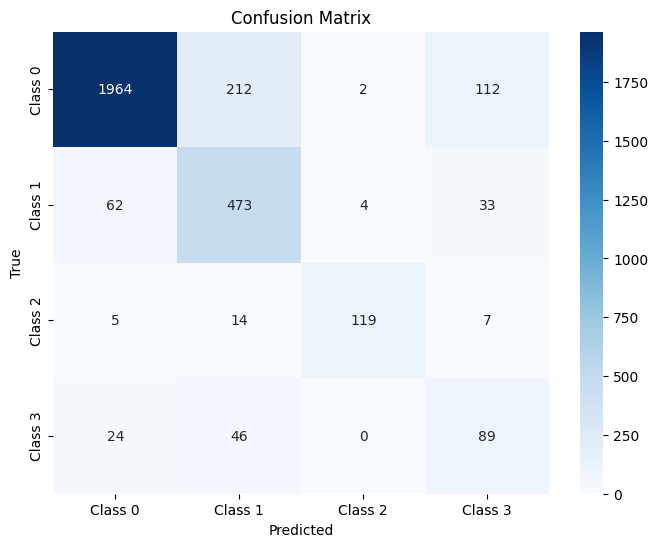

In [38]:
# Prediction

y_pred_probs = model.predict(x_test_encoded)
y_pred = np.argmax(y_pred_probs, axis=1)

# Convert true labels to one-hot encoding for evaluation
y_test_onehot = to_categorical(y_test, num_classes=4)

# Evaluation metrics
from sklearn.metrics import accuracy_score, classification_report

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix (optional)
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Class 0', 'Class 1', 'Class 2', 'Class 3'],
            yticklabels=['Class 0', 'Class 1', 'Class 2', 'Class 3'])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()